## **Import thư viện cần thiết**

In [9]:
# General imports
import pandas as pd
import numpy as np
import os
import shutil
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Processing
import tensorflow
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, AveragePooling2D

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# K-fold cross validation
from sklearn.model_selection import KFold

## **Split Val, Test Dataset**

In [ ]:
# Đường dẫn tới thư mục Testing
train_dir = '/kaggle/input/dataset-processing-equalhist-filternoise-edges/brain-tumor-mri-equalHist-FilterNoise-Edges-dataset/Training'
test_dir = '/kaggle/input/dataset-processing-equalhist-filternoise-edges/brain-tumor-mri-equalHist-FilterNoise-Edges-dataset/Testing'

# Đường dẫn mới cho các thư mục val và test
train_new_dir = '/kaggle/working/Brain_Tumor_NewDataset/Training'
val_dir = '/kaggle/working/Brain_Tumor_NewDataset/Valing'
test_new_dir = '/kaggle/working/Brain_Tumor_NewDataset/Testing'

# Tạo các thư mục con cho val và test
os.makedirs(train_new_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_new_dir, exist_ok=True)

In [ ]:
# Lấy danh sách các thư mục con trong thư mục Testing (từng loại ung thư)
class_names = os.listdir(test_dir)

# Tạo các thư mục con cho từng loại trong cả thư mục val, test và train
for class_name in class_names:
    os.makedirs(os.path.join(train_new_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_new_dir, class_name), exist_ok=True)

In [ ]:
# Chia các hình ảnh trong từng thư mục con
for class_name in class_names:
    # Lấy danh sách các hình ảnh trong thư mục của từng lớp
    class_path = os.path.join(test_dir, class_name)
    image_files = os.listdir(class_path)

    # Xáo trộn danh sách hình ảnh để chia ngẫu nhiên
    random.shuffle(image_files)

    # Chia đôi danh sách hình ảnh
    split_idx = len(image_files) // 2
    val_images = image_files[:split_idx]
    test_images = image_files[split_idx:]

    # Sao chép các hình ảnh vào thư mục mới (val và test)
    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_dir, class_name, image))
    
    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_new_dir, class_name, image))

print("Đã chia thư mục test thành 2 phần: val và test.")

In [ ]:
for class_name in class_names:
    # Lấy danh sách các hình ảnh trong thư mục của từng lớp
    class_path = os.path.join(train_dir, class_name)
    train_images = os.listdir(class_path)
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_new_dir, class_name, image))
print("Đã thêm thư mục train.")    

## **Loading Image Dataset from Directory**

In [2]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = r'/kaggle/working/Brain_Tumor_NewDataset/Training',
    labels='inferred',  # Keras tự lấy nhãn bằng tên của thư mục con
    label_mode='int',   # Nhãn sẽ được rán bằng số nguyên bắt đầu từ 0
    batch_size=64,
    image_size=(256, 256),
)

val_ds = keras.utils.image_dataset_from_directory(
    directory = r'/kaggle/working/Brain_Tumor_NewDataset/Valing',
    labels='inferred',  # Keras tự lấy nhãn bằng tên của thư mục con
    label_mode='int',   # Nhãn sẽ được rán bằng số nguyên bắt đầu từ 0
    batch_size=64,
    image_size=(256, 256),
)

test_ds = keras.utils.image_dataset_from_directory(
    directory = r'/kaggle/working/Brain_Tumor_NewDataset/Testing',
    labels='inferred',  # Keras tự lấy nhãn bằng tên của thư mục con
    label_mode='int',   # Nhãn sẽ được rán bằng số nguyên bắt đầu từ 0
    batch_size=64,
    image_size=(256, 256),
)


Found 5712 files belonging to 4 classes.
Found 655 files belonging to 4 classes.
Found 656 files belonging to 4 classes.


## **Model Building**

In [ ]:
# Define the model architecture
model = Sequential([

    # Convolutional layer 1
    Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(),

    # Convolutional layer 2
    Conv2D(128, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    # Convolutional layer 3
    Conv2D(256, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),

    Flatten(),

    # Full connect layers
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    
    Dense(4, activation='softmax')
    
])

In [ ]:
model.summary()

## **Model Compilation**

In [ ]:
# Biên dịch mô hình
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## **Model Training**

In [ ]:
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True) # Dừng lại khi loss không tiếp tục giảm
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True) # Khi val_loss không giảm trong các epoch nhất định thì learning rate sẽ giảm 


# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    verbose=1, # Hiển thị thanh tiến trình huấn luyện của mỗi epoch gồm loss, accuracy
    callbacks=[model_es, model_rlr]
)

## **Model Evaluation**

In [ ]:
# Evaluating the model
loss, accuracy = model.evaluate(val_ds)
print(f"Val Loss: {loss:0.5f}")
print(f"Val Accuracy: {accuracy:0.5f}")

## **Plotting the Graphs of Accuracy and Loss**

In [ ]:
# Plotting the graph of Accuracy and Validation Accuracy
plt.title('Training Accuracy vs Validation Accuracy')

plt.plot(history.history['accuracy'], color='red',label='Train')
plt.plot(history.history['val_accuracy'], color='blue',label='Validation')

plt.legend()

In [ ]:
# Plotting the graph of Accuracy and Validation loss
plt.title('Training Loss vs Validation Loss')

plt.plot(history.history['loss'], color='red',label='Train')
plt.plot(history.history['val_loss'], color='blue',label='Validation')

plt.legend()

## **Confusion Matrix and Classification Report**

In [ ]:
def plot_confusion_matrix(model, data_generator, classes):
    all_preds = []
    all_labels = []

    # Lặp qua dữ liệu trong data_generator
    for images, labels in data_generator:
        predictions = model.predict(images)  # Dự đoán nhãn
        predicted_class = np.argmax(predictions, axis=1)  # Lấy lớp có xác suất cao nhất

        # Lưu trữ nhãn thực tế và nhãn dự đoán
        all_preds.extend(predicted_class)
        all_labels.extend(labels.numpy())  # Chuyển nhãn thành mảng numpy nếu là Tensor

    # Tính ma trận 
    cm = confusion_matrix(all_labels, all_preds)

    # Vẽ ma trận 
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Trả về nhãn thực tế và nhãn dự đoán
    return all_preds, all_labels

In [ ]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Tính toán ma trận và báo cáo phân loại
all_preds, all_labels = plot_confusion_matrix(model, val_ds, classes)

# In báo cáo phân loại
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=classes))

## **Saving The Model**

In [ ]:
model_path = "/kaggle/working/result_model_new.keras"
model.save(model_path)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('/kaggle/working/training_history_new.csv', index=False)

In [ ]:
df = pd.read_csv("/kaggle/working/training_history.csv")
df.head(5)

## **Predict on Test dataset**

In [2]:
def plot_sample_predictions(model, test_generator, categories, num_samples=15, figsize=(13, 12)):
    # Lấy một batch dữ liệu từ test_generator
    images, labels = next(iter(test_generator))  # Lấy một batch dữ liệu
    
    # Dự đoán từ mô hình
    predictions = model.predict(images)
    
    # Cấu hình kích thước đồ thị
    plt.figure(figsize=figsize)
    
    # Duyệt qua số lượng hình ảnh cần hiển thị
    for i in range(num_samples):
        ax = plt.subplot(5, 5, i + 1)
        
        # Hiển thị hình ảnh
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Nhãn dự đoán
        predicted_class = categories[np.argmax(predictions[i])]
        
        # Nhãn thực tế
        true_class = categories[labels[i]]
        
        # Tiêu đề hiển thị True và Predicted
        plt.title(f"Truth: {true_class}\nPred: {predicted_class}")
        plt.axis('off')  # Tắt trục để sạch sẽ hơn
    
    # Căn chỉnh và hiển thị đồ thị
    plt.tight_layout()
    plt.show()

    # Lấy nhãn dự đoán và nhãn thực tế cho toàn bộ tập test
    y_true = []
    y_pred = []
    
    for images, labels in test_generator:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))  # Chuyển output dự đoán sang lớp số
    
    # Tính toán các chỉ số đánh giá
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=categories))
    
    # Tính accuracy chung
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")




I0000 00:00:1732786305.286578      95 service.cc:145] XLA service 0x7ac81c002ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732786305.286642      95 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


I0000 00:00:1732786308.539420      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


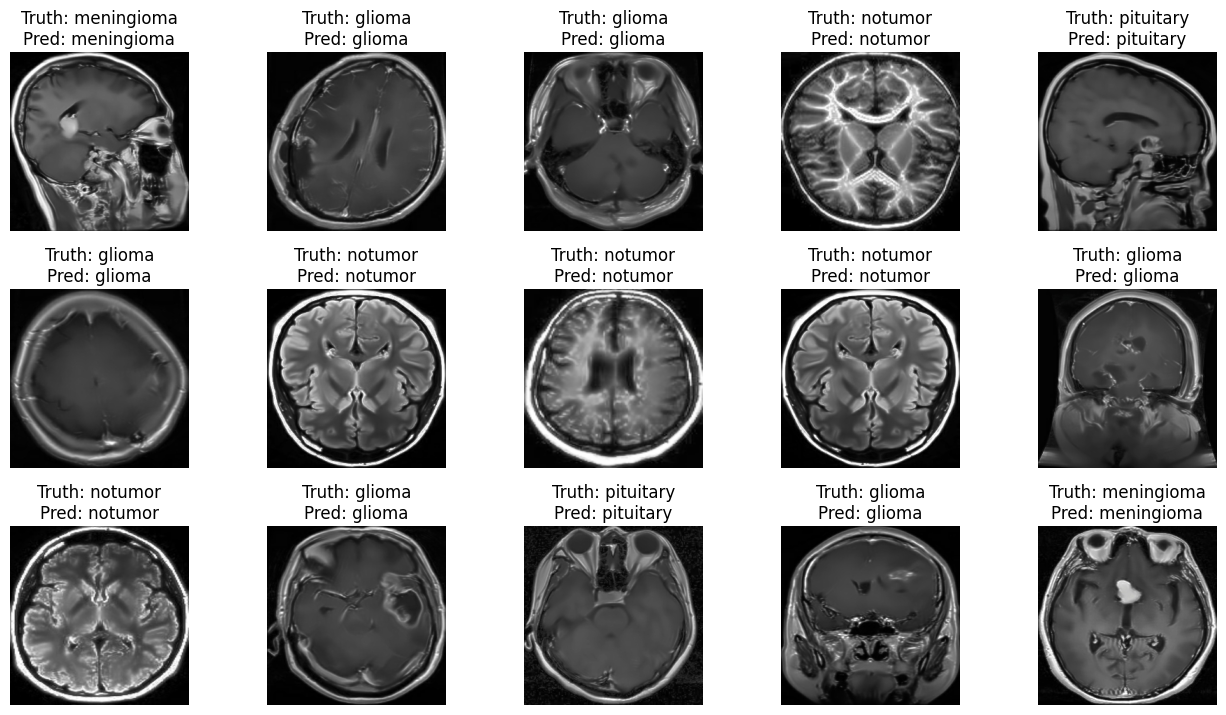

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       150
  meningioma       1.00      0.91      0.95       153
     notumor       0.94      1.00      0.97       203
   pituitary       1.00      1.00      1.00       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656

Accuracy: 0.9787


In [7]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Dự đoán trên tập test và hiển thị kết quả
plot_sample_predictions(
    model=model,               # Mô hình đã huấn luyện
    test_generator=test_ds,     # Hoặc test_ds nếu bạn sử dụng test dataset
    categories=classes,        # Danh sách các lớp
    num_samples=15,             # Số lượng hình ảnh muốn hiển thị
    figsize=(13, 12)           # Kích thước của figure
)

## **Load model**

In [4]:
model_path = '/kaggle/working/result_model_new.keras'
model = tensorflow.keras.models.load_model(model_path)

## **Model Evaluation**

In [ ]:
# Đánh giá trên tập val
loss, accuracy = model.evaluate(val_ds)
print(f"Val Loss: {loss:0.5f}")
print(f"Val Accuracy: {accuracy:0.5f}")

In [ ]:
# Đánh giá trên tập test
loss, accuracy = model.(test_ds)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

## **K-fold cross validation**

In [7]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.shape)
    print("Labels shape: ", label.shape)

Image shape:  (64, 256, 256, 3)
Labels shape:  (64,)


In [10]:
# Kết hợp train_ds, val_ds, test_ds thành 1 dataset
combined_ds = train_ds.concatenate(val_ds).concatenate(test_ds)

In [13]:
# Chuyển đổi label thành numpy arrays
def dataset_to_numpy(dataset):
    images = []
    labels = []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images), np.concatenate(labels)

X, y = dataset_to_numpy(combined_ds)
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

Shape of X: (7023, 256, 256, 3), Shape of y: (7023,)


In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}")

    # Chia dữ liệu theo index
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Load mô hình
    model = tensorflow.keras.models.load_model("/kaggle/working/result_model_new.keras")

    # Huấn luyện model
    model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

    # Đánh giá mô hình
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Accuracy for fold {fold + 1}: {val_accuracy:.4f}")


Fold 1
Epoch 1/5


I0000 00:00:1732983650.965256      72 service.cc:145] XLA service 0x7837e00070f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732983650.965325      72 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/88 ━━━━━━━━━━━━━━━━━━━━ 19:55 14s/step - accuracy: 1.0000 - loss: 0.0000e+00

I0000 00:00:1732983662.796666      72 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1732983662.803541      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9970 - loss: 0.4119

I0000 00:00:1732983684.285504      72 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 4 bytes spill stores, 12 bytes spill loads



88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 339ms/step - accuracy: 0.9970 - loss: 0.4127 - val_accuracy: 0.9979 - val_loss: 0.6425
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.9945 - loss: 1.3911 - val_accuracy: 0.9979 - val_loss: 0.5067
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.9939 - loss: 1.5037 - val_accuracy: 0.9993 - val_loss: 0.4426
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.9957 - loss: 0.5206 - val_accuracy: 0.9993 - val_loss: 0.4082
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.9969 - loss: 0.5008 - val_accuracy: 0.9993 - val_loss: 0.3864
Validation Accuracy for fold 1: 0.9993

Fold 2
Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 203ms/step - accuracy: 0.9939 - loss: 1.3894 - val_accuracy: 0.9986 - val_loss: 0.0946
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.9966 - loss: 0.4860 - val_accuracy: 0.9993 - val_loss: 0.0413
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.9

I0000 00:00:1732984000.802679      71 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 4 bytes spill stores, 12 bytes spill loads



88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 339ms/step - accuracy: 0.9942 - loss: 0.6387 - val_accuracy: 0.9979 - val_loss: 0.2449
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.9965 - loss: 1.0075 - val_accuracy: 0.9979 - val_loss: 0.1746
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.9964 - loss: 0.6218 - val_accuracy: 0.9979 - val_loss: 0.1318
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.9971 - loss: 0.7848 - val_accuracy: 0.9986 - val_loss: 0.0976
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.9991 - loss: 0.1068 - val_accuracy: 0.9986 - val_loss: 0.0884
Validation Accuracy for fold 4: 0.9986

Fold 5
Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - accuracy: 0.9958 - loss: 0.8719 - val_accuracy: 0.9972 - val_loss: 0.6290
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.9956 - loss: 0.3593 - val_accuracy: 0.9979 - val_loss: 0.5529
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.9

### => Mô hình không bị overfiting